In [ ]:
# IMPORTS
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import os
import pandas as pd
from skimage import color
from skimage import io

In [ ]:
drive = True

if drive:
    from google.colab import drive
    # MOUNT DRIVE
    drive.mount('/content/drive')
    data_path = '/content/drive/My Drive/DeepLearning_2023/Final/Data/'
    raw_data_path = '/content/drive/My Drive/DeepLearning_2023/Final/Data/raw_samples/'
    synth_data_path = '/content/drive/My Drive/DeepLearning_2023/Final/Data/synth_samples/'
    results_path = '/content/drive/My Drive/DeepLearning_2023/Final/Results/'
else: # LOCAL
    data_path = './Data/'
    raw_data_path = './Data/raw_samples/'
    results_path = './Results/'

Mounted at /content/drive


In [ ]:
# UTILS
def single_character_to_int(c): # Converts char to int label
    if c.isdigit():
        return int(c)
    else:
        return int(ord(c) - 87)
    
def int_to_single_character(i): # Converts int label to char
    if i<10:
        return str(i)
    else:
        return str(chr(i + 87))

def squareImage(img, target_size = 192): # INPUT IMG MUST BE PIL IMAGE RGBA: RETURNS NUMPY ARRAY OF SIZE 192x192x4
    if img.mode == "RGBA":
        channels = 4
    elif img.mode == "RGB":
        channels = 3
    else:
        print("Image with wrong mode")
    img_np = np.array(img.getdata()).reshape(img.size[1], img.size[0], channels)
    #PADDING
    y,x,_ = img_np.shape
    pad_y = max(0, (target_size - y)//2)
    pad_x = max(0, (target_size - x)//2)
    img_np = np.pad(img_np, ((pad_y, pad_y),(pad_x, pad_x),(0, 0)), "edge")
    # CROPPING
    y,x,_ = img_np.shape
    startx = x//2-(target_size//2)
    starty = y//2-(target_size//2)    
    img_np = img_np[starty:starty+192,startx:startx+192]
    return img_np

In [ ]:
#CaptchaDataset class
class CaptchaDataset(torch.utils.data.Dataset):
    #characters = ['a''b''c''d''e''f''g''h''i''j''k''l''m''n''o''p''q''r''t''u''v''w''x''y''z']
    #numbers = ['1''2''3''4''5''6''7''8''9''10''11''12''13''14''15''16''17''18''19''20''21''22''23''24']
    # Initialization method for the dataset
    def __init__(self, dataPath = raw_data_path, transform = None, target_char=0):
        self.data = []
        self.labels = []
        directory_files = os.listdir(dataPath)
        for filename in directory_files:
            self.data.append(np.array(squareImage(Image.open(dataPath+filename)))[:,:,0])
            #self.data.append(np.array(Image.open(dataPath+filename))[:,:,0])
            #self.labels.append(filename[:-4])
            self.labels.append(single_character_to_int(filename[target_char]))
        self.data=np.array(self.data)
        self.transform = transform    

    # What to do to load a single item in the dataset ( read image and label)    
    def __getitem__(self, index):
        data = self.data[index]
        lbl = self.labels[index]
        data = Image.fromarray((data).astype(np.uint8))
        # Apply a trasnformaiton to the image if it is indicated in the initalizer
        if self.transform is not None : 
            data = self.transform(data)
        
        # return the image and the label
        return data,lbl
    
    # Return the number of images
    def __len__(self):
        return self.data.shape[0]

In [ ]:
# Image transformer
tr = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize(mean = [.5], std = [.5])
        ])

#Instantiating captchaDataset
captchaDataset = CaptchaDataset(raw_data_path, tr)
print("captchaDataset created:")
print(" ", len(captchaDataset), "images")
print(" ", captchaDataset.data.shape)

# Setting train and test sizes
train_size = int(len(captchaDataset) * 0.7)
test_size = len(captchaDataset) - train_size

# Dataset splitting (inputs Dataset and outputs a dataset.Subset (which has same properties and methods as Dataset)))
train_set, test_set = torch.utils.data.random_split(captchaDataset,[train_size,test_size])
print("Dataset splitted:")
print("  Training set len:", len(train_set))
print("  Testing set len:", len(test_set))

captchaDataset created:
  1070 images
  (1070, 192, 192)
Dataset splitted:
  Training set len: 749
  Testing set len: 321


m


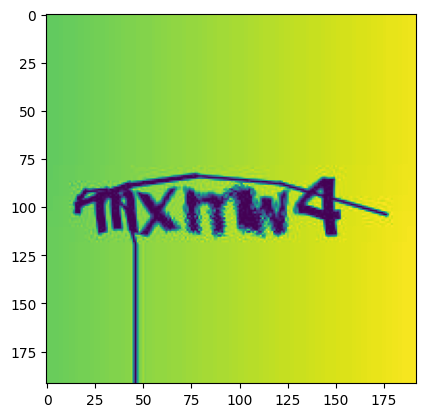

In [ ]:
# Dataset sample example
data, lbl = captchaDataset.__getitem__(250)
plt.imshow(data.numpy()[0])
print(int_to_single_character(lbl))

In [ ]:
class MyMobileNetV2(nn.Module):
    def __init__(self, num_classes=36):
        super(MyMobileNetV2, self).__init__()

        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.dropout1 = nn.Dropout(0.12)
        t = 1
        self.conv20 = nn.Conv2d(16, 16*t, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn20 = nn.BatchNorm2d(16*t)
        self.conv21 = nn.Conv2d(16*t, 16, kernel_size=3, stride=1, padding=1, groups=16, bias=False)
        self.bn21 = nn.BatchNorm2d(16)
        self.conv22 = nn.Conv2d(16, 32, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn22 = nn.BatchNorm2d(32)

        t = 4
        self.conv30 = nn.Conv2d(32, 32*t, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn30 = nn.BatchNorm2d(32*t)
        self.conv31 = nn.Conv2d(32*t, 32, kernel_size=3, stride=1, padding=1, groups=32, bias=False)
        self.bn31 = nn.BatchNorm2d(32)
        self.conv32 = nn.Conv2d(32, 64, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn32 = nn.BatchNorm2d(64)

        self.conv40 = nn.Conv2d(64, 64*t, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn40 = nn.BatchNorm2d(64*t)
        self.conv41 = nn.Conv2d(64*t, 64, kernel_size=3, stride=1, padding=1, groups=64, bias=False)
        self.bn41 = nn.BatchNorm2d(64)
        self.conv42 = nn.Conv2d(64, 128, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn42 = nn.BatchNorm2d(128)
        self.dropout4 = nn.Dropout(0.1)

        self.conv50 = nn.Conv2d(128, 128*t, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn50 = nn.BatchNorm2d(128*t)
        self.conv51 = nn.Conv2d(128*t, 128, kernel_size=3, stride=1, padding=1, groups=128, bias=False)
        self.bn51 = nn.BatchNorm2d(128)
        self.conv52 = nn.Conv2d(128, 128, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn52 = nn.BatchNorm2d(128)

        self.conv60 = nn.Conv2d(128, 128*t, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn60 = nn.BatchNorm2d(128*t)
        self.conv61 = nn.Conv2d(128*t, 128, kernel_size=3, stride=1, padding=1, groups=128, bias=False)
        self.bn61 = nn.BatchNorm2d(128)
        self.conv62 = nn.Conv2d(128, 256, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn62 = nn.BatchNorm2d(256)

        t = 4
        self.conv70 = nn.Conv2d(256, 256*t, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn70 = nn.BatchNorm2d(256*t)
        self.conv71 = nn.Conv2d(256*t, 256, kernel_size=3, stride=1, padding=1, groups=256, bias=False)
        self.bn71 = nn.BatchNorm2d(256)
        self.conv72 = nn.Conv2d(256, 256, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn72 = nn.BatchNorm2d(256)
        self.dropout7 = nn.Dropout(0.15)

        self.conv80 = nn.Conv2d(256, 256*t, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn80 = nn.BatchNorm2d(256*t)
        self.conv81 = nn.Conv2d(256*t, 256, kernel_size=3, stride=1, padding=1, groups=256, bias=False)
        self.bn81 = nn.BatchNorm2d(256)
        self.conv82 = nn.Conv2d(256, 512, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn82 = nn.BatchNorm2d(512)

        t=1
        self.conv90 = nn.Conv2d(512, 512*t, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn90 = nn.BatchNorm2d(512*t)
        self.conv91 = nn.Conv2d(512*t, 512, kernel_size=3, stride=1, padding=1, groups=256, bias=False)
        self.bn91 = nn.BatchNorm2d(512)
        self.conv92 = nn.Conv2d(512, 512, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn92 = nn.BatchNorm2d(512)

        self.relu6 = nn.ReLU6(inplace=True)
        self.MaxPool2d= nn.MaxPool2d(kernel_size=2, stride=2)
        self.AvgPool2d = nn.AvgPool2d(12)
        #self.fc1 = nn.Linear(512, 256)
        self.dropoutFc = nn.Dropout(0.15)
        #self.fc2 = nn.Linear(256, num_classes)
        self.fc = nn.Linear(512, num_classes)
    

    def forward(self, x):
      
        #print(x.shape) -> INPUT: (192, 192, 1)
        out = self.relu6(self.bn1(self.conv1(x))) #-> OUTPUT: (192, 192, 16)
        out = self.dropout1(out)
        out = self.relu6(self.bn22(self.conv22(self.relu6(self.bn21(self.conv21(self.relu6(self.bn20(self.conv20(out))))))))) #-> OUTPUT: (192, 192, 32)
        out = self.MaxPool2d(out) #-> OUTPUT: (96, 96, 32)
        out = self.relu6(self.bn32(self.conv32(self.relu6(self.bn31(self.conv31(self.relu6(self.bn30(self.conv30(out))))))))) #-> OUTPUT: (96, 96, 64)
        out = self.relu6(self.bn42(self.conv42(self.relu6(self.bn41(self.conv41(self.relu6(self.bn40(self.conv40(out))))))))) #-> OUTPUT: (96, 96, 128)
        out = self.dropout4(out)
        out = self.MaxPool2d(out) #-> OUTPUT: (48, 48, 128)
        out = self.relu6(self.bn52(self.conv52(self.relu6(self.bn51(self.conv51(self.relu6(self.bn50(self.conv50(out)))))))))+out  #-> OUTPUT: (48, 48, 128)
        out = self.relu6(self.bn62(self.conv62(self.relu6(self.bn61(self.conv61(self.relu6(self.bn60(self.conv60(out)))))))))  #-> OUTPUT: (48, 48, 256)
        out = self.relu6(self.bn72(self.conv72(self.relu6(self.bn71(self.conv71(self.relu6(self.bn70(self.conv70(out)))))))))+out #-> OUTPUT: (48, 48, 256)
        out = self.dropout7(out)
        out = self.MaxPool2d(out) #-> OUTPUT: (24, 24, 256)
        out = self.relu6(self.bn82(self.conv82(self.relu6(self.bn81(self.conv81(self.relu6(self.bn80(self.conv80(out))))))))) #-> OUTPUT: (24, 24, 512)
        out = self.MaxPool2d(out) #-> OUTPUT: (12, 12, 512)
        out = self.relu6(self.bn92(self.conv92(self.relu6(self.bn91(self.conv91(self.relu6(self.bn90(self.conv90(out))))))))) #-> OUTPUT: (12, 12, 512)
        out = self.AvgPool2d(out) #-> OUTPUT: (1, 1, 512)
        out = torch.flatten(out, 1)
        #out = self.fc1(out)
        #out = self.fc2(out)
        out = self.dropoutFc(out)
        out = self.fc(out)
        return out

In [ ]:
'''class RNNNetwork(nn.Module):
  def __init__(self,
               input_size : int = 36,
               hidden_size : int = 64, 
               out_size : int = 36,
               num_layers = 3,
               num_letters = 36,
               letters_embedding_size : int = 36,
               use_lstm : bool = False):
    # Define RNN or LSTM architecture
    super().__init__()
    self.hidden_size = hidden_size
    self.num_letters = num_letters
    self.letters_embedder = torch.nn.Embedding(num_letters, letters_embedding_size)
    self.use_lstm = use_lstm
    self.softmax = nn.Softmax(dim=1)
    if(use_lstm):
      self.rnn =  nn.LSTM(input_size = input_size, hidden_size = hidden_size, 
                          num_layers=num_layers, batch_first = True)
    else:
      self.rnn =  nn.RNN(input_size = input_size, hidden_size = hidden_size, 
                         num_layers=num_layers, batch_first = True)
    self.last_linear = nn.Linear(hidden_size,num_letters)

  def forward(self, X):
    N = X.shape[0]
    L = X.shape[1]
    embedded_letters = self.letters_embedder(X.long())
    # Get hidden states for all letters in the sequence
    hidden_states,_ = self.rnn(embedded_letters)
    # In case of multiple input sequneces flat (N,L,hidden_size) to (N*L,hidden_size) for linear layer
    hidden_states_concat = hidden_states.reshape(-1,self.hidden_size) 
    # Get letters probability using the hidden states for each position in the sequence
    letters_loggits = self.last_linear(hidden_states_concat)
    #Use soft-max over logits and reshape to format (N,L,num_letteres)
    letters_probs = self.softmax(letters_loggits).reshape(N,L,self.num_letters)
    return letters_probs'''

'class RNNNetwork(nn.Module):\n  def __init__(self,\n               input_size : int = 36,\n               hidden_size : int = 64, \n               out_size : int = 36,\n               num_layers = 3,\n               num_letters = 36,\n               letters_embedding_size : int = 36,\n               use_lstm : bool = False):\n    # Define RNN or LSTM architecture\n    super().__init__()\n    self.hidden_size = hidden_size\n    self.num_letters = num_letters\n    self.letters_embedder = torch.nn.Embedding(num_letters, letters_embedding_size)\n    self.use_lstm = use_lstm\n    self.softmax = nn.Softmax(dim=1)\n    if(use_lstm):\n      self.rnn =  nn.LSTM(input_size = input_size, hidden_size = hidden_size, \n                          num_layers=num_layers, batch_first = True)\n    else:\n      self.rnn =  nn.RNN(input_size = input_size, hidden_size = hidden_size, \n                         num_layers=num_layers, batch_first = True)\n    self.last_linear = nn.Linear(hidden_size,num_letter

In [ ]:
'''# Definición de la arquitectura que combina la CNN y la RNN
class CNN_RNN(nn.Module):
    def __init__(self, cnn, rnn):
        super(CNN_RNN, self).__init__()
        self.cnn = cnn
        self.rnn = rnn

    def forward(self, x):
        bach_size, channels, height, width = x.size()
        print(x.shape)
        
        x = self.cnn(x)
        print(x.shape)
        #x = x.squeeze(2)  # Eliminar la dimensión adicional
        #x = x.permute(0, 2, 1)  # Permutar dimensiones para que coincida con la entrada de la RNN
        x = self.rnn(x)
        return x

# Ejemplo de uso
cnn = MyMobileNetV2()
rnn = RNNNetwork(input_size=36, hidden_size=64, out_size=36 )  # Ejemplo: salida con 10 clases
model = CNN_RNN(cnn,rnn)
model = model.to(torch.device('cuda'))


# Entrada de ejemplo
batch_size = 16
input_channels = 1
image_height = 192
image_width = 192
sequence_length = 5
train_loader = torch.utils.data.DataLoader(dataset=train_set,
                                               batch_size=16, 
                                               shuffle=True)
for i, (images, labels) in enumerate(train_loader):
            # Get batch of samples and labels
            images = images.to('cuda')
            #labels = labels.type(torch.LongTensor).to('cuda')

            # Forward pass
            print(images.shape)
            images = images.to(torch.device('cuda'))  # Utilizar GPU si está disponible
            print(images.shape)
            output = model(images)
            print(output.shape) 
            break


'''

"# Definición de la arquitectura que combina la CNN y la RNN\nclass CNN_RNN(nn.Module):\n    def __init__(self, cnn, rnn):\n        super(CNN_RNN, self).__init__()\n        self.cnn = cnn\n        self.rnn = rnn\n\n    def forward(self, x):\n        bach_size, channels, height, width = x.size()\n        print(x.shape)\n        \n        x = self.cnn(x)\n        print(x.shape)\n        #x = x.squeeze(2)  # Eliminar la dimensión adicional\n        #x = x.permute(0, 2, 1)  # Permutar dimensiones para que coincida con la entrada de la RNN\n        x = self.rnn(x)\n        return x\n\n# Ejemplo de uso\ncnn = MyMobileNetV2()\nrnn = RNNNetwork(input_size=36, hidden_size=64, out_size=36 )  # Ejemplo: salida con 10 clases\nmodel = CNN_RNN(cnn,rnn)\nmodel = model.to(torch.device('cuda'))\n\n\n# Entrada de ejemplo\nbatch_size = 16\ninput_channels = 1\nimage_height = 192\nimage_width = 192\nsequence_length = 5\ntrain_loader = torch.utils.data.DataLoader(dataset=train_set,\n                        

In [ ]:
# Train function
def train(CNN, train_loader, optimizer, num_epochs=5, model_name='model.ckpt', device='cpu', test_loader=None):
    CNN.train() # Set the model in train mode
    total_step = len(train_loader)
    losses_list = []
    accuracies = []
    criterion = nn.CrossEntropyLoss()
    # Iterate over epochs
    for epoch in range(num_epochs):
        # Iterate the dataset
        loss_avg = 0
        nBatches = 0
        for i, (images, labels) in enumerate(train_loader):
            # Get batch of samples and labels
            images = images.to(device)
            labels = labels.type(torch.LongTensor).to(device)

            # Forward pass
            outputs = CNN(images)
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_avg += loss.cpu().item()
            nBatches+=1
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch+1, num_epochs, i+1, total_step, loss_avg / nBatches))
        print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch+1, num_epochs, i+1, total_step, loss_avg / nBatches))
        losses_list.append(loss_avg / nBatches)
        if test_loader != None:
            CNN.eval()
            acc = test(CNN, test_loader)
            accuracies.append(acc)
            print("Accuracy: {:.4f}%".format(acc))
            CNN.train()
        torch.save(CNN.state_dict(), results_path+ '/' + model_name)
          
    return losses_list, accuracies

# Test funcion
def test(CNN, test_loader, display_errors=False):
    CNN.eval()
    with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                # get network predictions
                outputs = CNN(images)

                # get predicted class
                _, predicted = torch.max(outputs.data, 1)

                # compare with the ground-truth
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                if display_errors:
                    for i in range(max(5, len(labels))):
                        if predicted[i] != labels[i]:
                            print('Real label: ' + str(labels[i]))
                            print('Predicted label: ' + str(predicted[i]))
                            print(display(plt.imshow(images[i][0].cpu().numpy())))
                            plt.show()
            # return accuracy
            return 100 * correct / total

In [ ]:
#Train MyModel
model = MyMobileNetV2(num_classes=36)

#Initialize optimizer 
learning_rate = .001
#optimizer = torch.optim.SGD(model.parameters(),lr = learning_rate, 
                            #weight_decay=1e-5, momentum=0.85)

optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)



device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = model.to(device)
train_loader = torch.utils.data.DataLoader(dataset=train_set,
                                               batch_size=32, 
                                               shuffle=True)

losses_list = train(model, train_loader, optimizer, num_epochs=12, device=device)

Epoch [1/12], Step [24/24], Loss: 3.0254
Epoch [2/12], Step [24/24], Loss: 2.6342
Epoch [3/12], Step [24/24], Loss: 2.4365
Epoch [4/12], Step [24/24], Loss: 2.2710
Epoch [5/12], Step [24/24], Loss: 1.8676
Epoch [6/12], Step [24/24], Loss: 1.3447
Epoch [7/12], Step [24/24], Loss: 0.8696
Epoch [8/12], Step [24/24], Loss: 0.5190
Epoch [9/12], Step [24/24], Loss: 0.2977
Epoch [10/12], Step [24/24], Loss: 0.1494
Epoch [11/12], Step [24/24], Loss: 0.0873
Epoch [12/12], Step [24/24], Loss: 0.0620


In [ ]:
# Show results for all the trained models
test_loader = torch.utils.data.DataLoader(dataset=test_set,
                                               batch_size=256,
                                               shuffle=True)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

my_net = MyMobileNetV2()
my_net.load_state_dict(torch.load(results_path + 'model.ckpt'))
my_net.cuda()
acc = test(my_net, test_loader, display_errors=False)
print('Accuracy MyNet: ' + str(round(acc, 3)) + "%")

Accuracy MyNet: 90.031%


tensor(3)
torch.Size([1, 1, 192, 192])
tensor(6.9399, device='cuda:0', grad_fn=<SelectBackward0>)
Predicted:  3
[[-5.674116   -5.1601944   2.4478045   6.939949    3.5238292   2.923088
  -0.1876509   0.72031546  4.2910295  -4.9305663  -5.7245364  -0.20053285
  -2.460085   -0.78330237  0.35807392  0.2612645  -0.5662669  -5.529583
  -5.4328523  -5.939035   -5.7604723  -5.496551   -1.0490644  -2.5255926
  -5.2857137  -2.36274    -5.87847    -5.46817    -5.5243278  -5.0399017
  -5.071109   -5.4476285  -0.52984905 -0.53166145 -2.3425808  -5.8100867 ]]


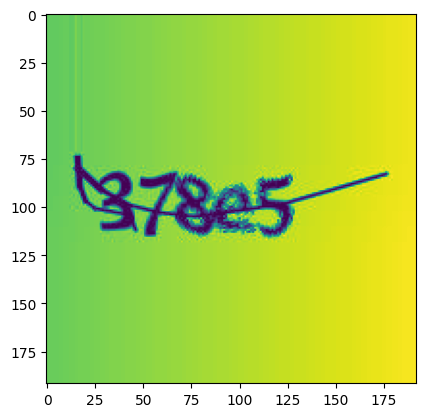

In [ ]:

inputs, classes = next(iter(test_loader))
plt.imshow(inputs[0].numpy()[0])
print(classes[0])
inputs = inputs[0:1].to(device)
print(inputs.shape)
out = my_net(inputs)
print(out)
_, predicted = torch.max(out, 1)
print(out[0, classes[0]])
print("Predicted: ", int_to_single_character(predicted.cpu().numpy()[0]))
print(out.cpu().detach().numpy())

## 5 CNNs (one for each of the 5 characters)

In [ ]:
CAPTCHA_LEN = 5

captchaDatasets_by_target = []
train_sets = []
test_sets = []

for i in range(CAPTCHA_LEN):
#Instantiating captchaDataset
    captchaDatasets_by_target.append(CaptchaDataset(raw_data_path, tr, target_char = i))
    train_sets.append(None)
    test_sets.append(None)
    train_sets[i], test_sets[i] = torch.utils.data.random_split(captchaDatasets_by_target[i],[train_size,test_size], generator=torch.Generator().manual_seed(42))

m


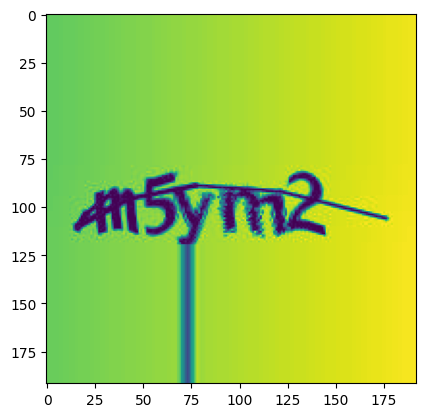

In [ ]:
data, lbl = captchaDatasets_by_target[0].__getitem__(251)
plt.imshow(data.numpy()[0])
print(int_to_single_character(lbl))

In [ ]:
CAPTCHA_LEN = 5

# CURRENT BEST: epochs=20, lr=0.00075
epochs = 30 # USE 12-14 with .001 or 20 with .00075
learning_rate = .001 # CURRENT BEST: .001 or .00075
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

CNNs_5 = []
optimizers = []
train_loaders = []
losses_lists = []
accuracies_by_epoch = []

for i in range(5):
    CNNs_5.append(MyMobileNetV2(num_classes=36))
    optimizers.append(torch.optim.Adam(CNNs_5[i].parameters(),lr = learning_rate))
    CNNs_5[i] = CNNs_5[i].to(device)
    train_loaders.append(torch.utils.data.DataLoader(dataset=train_sets[i], batch_size=32, shuffle=True))
    test_loader = torch.utils.data.DataLoader(dataset=test_sets[i], batch_size=256, shuffle=True)
    print("TRAINING CNN FOR CHARACTER", i)
    loss_list_aux, acc_aux = train(CNNs_5[i], train_loaders[i], optimizers[i], num_epochs=epochs, device=device, model_name="char" + str(i) +"_model.ckpt", test_loader=test_loader)
    losses_lists.append(loss_list_aux)
    accuracies_by_epoch.append(acc_aux)

TRAINING CNN FOR CHARACTER 0
Epoch [1/30], Step [24/24], Loss: 3.0758
Accuracy: 9.6573%
Epoch [2/30], Step [24/24], Loss: 2.6778
Accuracy: 9.6573%
Epoch [3/30], Step [24/24], Loss: 2.4503
Accuracy: 9.6573%
Epoch [4/30], Step [24/24], Loss: 2.3037
Accuracy: 11.5265%
Epoch [5/30], Step [24/24], Loss: 1.9648
Accuracy: 9.6573%
Epoch [6/30], Step [24/24], Loss: 1.4862
Accuracy: 45.1713%
Epoch [7/30], Step [24/24], Loss: 1.0144
Accuracy: 33.6449%
Epoch [8/30], Step [24/24], Loss: 0.5866
Accuracy: 80.3738%
Epoch [9/30], Step [24/24], Loss: 0.3690
Accuracy: 62.3053%
Epoch [10/30], Step [24/24], Loss: 0.2070
Accuracy: 90.0312%
Epoch [11/30], Step [24/24], Loss: 0.1070
Accuracy: 93.4579%
Epoch [12/30], Step [24/24], Loss: 0.0795
Accuracy: 95.9502%
Epoch [13/30], Step [24/24], Loss: 0.0562
Accuracy: 96.2617%
Epoch [14/30], Step [24/24], Loss: 0.0694
Accuracy: 93.1464%
Epoch [15/30], Step [24/24], Loss: 0.0541
Accuracy: 96.8847%
Epoch [16/30], Step [24/24], Loss: 0.0254
Accuracy: 99.3769%
Epoch [1

In [ ]:
# Show results for all the trained models


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
accuracies5 = []

for i in range(len(CNNs_5)):
    test_loader = torch.utils.data.DataLoader(dataset=test_sets[i], batch_size=256, shuffle=True)
    my_net = CNNs_5[i]
    my_net.load_state_dict(torch.load(results_path + "char" + str(i) +"_model.ckpt"))
    my_net.cuda()
    acc = test(my_net, test_loader, display_errors=False)
    print('Accuracy for char ' + str(i) + ': ' + str(round(acc, 3)) + "%")
    accuracies5.append(acc)

print("Overall min accuracy: " + str(round(np.prod(accuracies5)/(100**len(accuracies5)), 3)) + "%")
print("Overall max accuracy: " + str(round(min(accuracies5), 3)) + "%")

In [ ]:
inputs, classes = next(iter(test_loader))
plt.imshow(inputs[0].numpy()[0])
#print(classes[0])
inputs = inputs[0:1].to(device)
#print(inputs.shape)
out1 = CNNs_5[0](inputs)
out2 = CNNs_5[1](inputs)
out3 = CNNs_5[2](inputs)
out4 = CNNs_5[3](inputs)
out5 = CNNs_5[4](inputs)

_, predicted1 = torch.max(out1, 1)
_, predicted2 = torch.max(out2, 1)
_, predicted3 = torch.max(out3, 1)
_, predicted4 = torch.max(out4, 1)
_, predicted5 = torch.max(out5, 1)

#print(out[0, classes[0]])
print("Predicted: ", (str(int_to_single_character(predicted1.cpu().numpy()[0])) +
                      str(int_to_single_character(predicted2.cpu().numpy()[0])) +
                      str(int_to_single_character(predicted3.cpu().numpy()[0])) + 
                      str(int_to_single_character(predicted4.cpu().numpy()[0])) +
                      str(int_to_single_character(predicted5.cpu().numpy()[0]))))
#print(out.cpu().detach().numpy())

In [ ]:
for loss_list in losses_lists:
    plt.plot(loss_list)
plt.show()

In [ ]:
for acc in accuracies_by_epoch:
    plt.plot(acc)
plt.show()